In [26]:
from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp

from scipy.interpolate import interp1d

import random

from sympy import *
    
import io_utilities as ioutil

from matplotlib import animation

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
''')



![title](figs/COMPGEOP_TITLE.jpg)

### <h1><center>Module 7: Differentiation and Discretization</center></h1>

This module is largely focused on theory and practice of taking **analytic** partial differential equations (PDEs) defined on a **continuum** such as the 1D advection equation:

$$\frac{\partial U}{\partial x} = \frac{1}{c}\frac{\partial U}{\partial t}, \tag{1} $$

and replacing it with a **discretized** version that is appropriate for generating **numerical solutions** on **discrete computational grid**.  

Why are we interested in doing such a thing? The answer largely lies in the fact that there are only a limited number of analytical solutions to almost all PDEs, and these are restricted to idealized scenarios (e.g., homogeneous medium, simple boundary conditions).  The real world, though, is inherently complex and cannot be simply defined by these idealized analytic scenarios. To address these situations, we must turn to **numerical solutions** of these PDEs.  In doing so, however, we run into a whole new class of challenges including **numerical stability**, **approximation accuracy**, and **computational efficiency** to name just a few. The purpose of this module is to start introducing some of these concepts within the context of numerical **differentiation** and **discretization**.   

## The Derivative Definition

Let's begin this module with a quick refresher on the definition of the derivative.  In your study of calculus over the previous number of years, you have no doubt encountered the following definition of the first derivative of function $f(t)$ defined on some interval $t\in[a,b]$:

$$ f^\prime(t) = \lim_{\Delta t\rightarrow 0} \frac{f(t+\Delta t)-f(t)}{\Delta t},  \tag{2}$$

where the $^\prime$ symbol indicates the derivative, and a small increment $\Delta t$. There are a number of other criteria that needs to be considered (e.g., continuity, differentiability); however, in this course we will assume that the functions under consideration are well-behaved such that these are not an issue.

### The Limits of Limits

Because we are interested in **discrete** solutions in this module, we are dealing with scenarios where we have some minimum **discrete** sampling of the continuous time axis: $\Delta t$. In these scenarios, we cannot take the limit of $\Delta t \rightarrow 0$ as is required by definition of the derivative.  Thus, we are left with a **numerical approximation** of the continuous derivative:

$$ f^\prime(t) = \frac{df}{dt} \approx \frac{\Delta f}{\Delta t} = \frac{f(t+\Delta t)-f(t)}{\Delta t}. \tag{3}$$

Note that we have had to introduce the approximate symbol $\approx$ since these are not formally equal.  However, we can introduce equality by rewriting this equation as

$$ f^\prime(t) = \frac{df}{dt} = \frac{f(t+\Delta t)-f(t)}{\Delta t} +\mathcal{O}(\Delta t^2), \tag{4}$$

where $\mathcal{O}(\Delta t^2)$ indicates that there are **higher-order terms** proportional to at least $\Delta t^2$ that contribute to this equation in this case **second-order** terms such that equation 4 represents a **first-order approximation**.  

To think of why this would be important, consider if $\Delta t < 1$ is small, then $\Delta t^2 << 1$ will be much smaller; thus, an $\mathcal{O}(\Delta t^2)$ apprximation will be more accurate than an $\mathcal{O}(\Delta t)$ one.  Note that the $\mathcal{O}(\Delta t^n)$ term is often implicitly assumed and is only written when required for clarity.

## Taylor Series

Let's now bring in Taylor Series to help us better understand why the above expression is only a first-order expression.  Recall that Taylor's theorem with remainder gives the following expression:

$$f(t+\Delta t) = f(t) + \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!}, \tag{5}$$

where it is assumed that all of the derivitives are evaluated at $t$ (and not $t+\Delta t$).  Rearranging this equation leads to the following:

$$\frac{f(t+\Delta t) - f(t)}{\Delta t} -f^\prime(t) =  \Delta t \frac{f^{\prime\prime}(t)}{2!},\tag{6}$$

the right-hand side of which tells us that the **numerical error** is proportional to $\Delta t$ and thus this expression represents a **first-order approximation**.  

### Forward and Backward Approximations

So far, it is likely that you have been thinking of $\Delta t$ as a small **positive** quantity; however, we did not formally include positivity in its definition.  This definition is called a **forward approximation** of $f^\prime(t)$ because it is defined using information at $t$ and $t+\Delta t$, which is $\Delta t$ forward of $t$.

Let's now say that we have new small **negative** quantity $\Delta t^\prime$ such that $\Delta t^\prime=-\Delta t$.  How does this affect the expression in equation 6?

$$\frac{f(t-\Delta t^\prime) - f(t)}{-\Delta t^\prime} - f^\prime(t) = \frac{f(t) - f(t-\Delta t^\prime) }{\Delta t^\prime} - f^\prime(t) = - \Delta t^\prime \frac{f^{\prime\prime}(t)}{2!} ,\tag{7}$$

Thus, the middle equality of equation 7 has the same form as equation 6; however, it now requires information at $t$ and $t-\Delta t$, which $\Delta t$ units back of $t$. Thus, this expression is called a **backward approximation** of $f^\prime(t)$.  You'll also note that the error is again proportional to $\Delta t^\prime$. Thus, as one may expect, this expression is also a **first-order approximation** just like equation 6.

## Higher-order Taylor Series Approximations

Let's now look at combining different Taylor Series approximations to see if we can generate a higher-order expression (i.e., the error term is proportional to at least $\Delta t^2$).  Here are the forward and backward Taylor Series approximations defined in equations 5 and 7 above, but now expanded out in a higher-order approximation:

$$f(t+\Delta t) = f(t) + \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!} + \Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}, \tag{8a}$$

$$f(t-\Delta t) = f(t) - \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!} - \Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}. \tag{8b}$$

Now, by subtracting equation 8b from equation 8a we can obtain the following:

$$f(t+\Delta t) - f(t-\Delta t) = 2 \Delta t f^\prime(t) + 2 \Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}. \tag{9a}$$

Rearranging this expression yields:

$$\frac{f(t+\Delta t)-f(t-\Delta t)}{2\Delta t} - f^\prime(t) = 2 \Delta t^2 \frac{f^{\prime\prime\prime}(t)}{3!}. \tag{9b}$$

Unlike equation 7, you'll notice that the right-hand side error term is now proportional to $\Delta t^2$. Thus, this represents a **second-order centered approximation** of $f^\prime(t)$.  Here, we use the term **centered** because this expressions depends on an equal number of points before ($t-\Delta t)$ and after ($t+\Delta t)$ the point being evaluated ($t$).

Can we go even higher? The answer is yes. However, the mathematics get a bit tedious.  I'll show a **fourth-order approximation** can be derived.

$$
\begin{eqnarray}
f(t+\Delta t) &=& f(t) + \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!} + \Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}+ \Delta t^4 \frac{f^{(4)}(t)}{4!}+ \Delta t^5 \frac{f^{(5)}(t)}{5!},\tag{10a} \\
f(t-\Delta t) &=& f(t) - \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!} - \Delta t^3 \frac{f^{(4)}(t)}{3!}+ \Delta t^4 \frac{f^{\prime\prime\prime}(t)}{4!}- \Delta t^5 \frac{f^{(5)}(t)}{5!},\tag{10b} \\
f(t+2\Delta t) &=& f(t) + 2\Delta t f^\prime(t) + 4\Delta t^2 \frac{f^{\prime\prime}(t)}{2!} + 8\Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}+ 16\Delta t^4 \frac{f^{(4)}(t)}{4!}+ 32\Delta t^5 \frac{f^{(5)}(t)}{5!},\tag{10c}\\
f(t-2\Delta t) &=& f(t) - 2\Delta t f^\prime(t) + 4\Delta t^2 \frac{f^{\prime\prime}(t)}{2!} - 8\Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}+ 16\Delta t^4 \frac{f^{(4)}(t)}{4!}- 32\Delta t^5 \frac{f^{(5)}(t)}{5!},\tag{10d}\\
\end{eqnarray}$$

If we first subtract equation 10b from equation 10a and multiply by 8, we obtain:

$$8f(t+\Delta t)-8f(t-\Delta t) = 16 \Delta t f^\prime(t)+\frac{16\Delta t ^3}{3!}f^{\prime\prime\prime}(t)+\frac{16\Delta t^5}{5!}f^{(5)}(t). \tag{10e}$$

If we then subtract equation 10d from equation 10c we get:

$$f(t+2\Delta t)-f(t-2\Delta t) = 4 \Delta t f^\prime(t)+\frac{16\Delta t^3}{3!}f^{\prime\prime\prime}(t)+\frac{64\Delta t^5}{5!}f^{(5)}(t). \tag{10f}$$

Finally, if we subtract equation 10e from equation 10f we obtain

$$f(t+2\Delta t)-8f(t+\Delta t)+8f(t-\Delta t)-f(t-2\Delta t) - 12 \Delta t f^\prime(t) = \frac{48\Delta t^5}{5!}f^{(5)}.\tag{10g} $$

Dividing through by $12 \Delta t$ yields:

$$\frac{f(t+2\Delta t)-8f(t+\Delta t)+8f(t-\Delta t)-f(t-2\Delta t)}{12 \Delta t} -  f^\prime(t) = \frac{4\Delta t^4}{5!}f^{(5)}. \tag{10g} $$

Thus, after all of this math, we see that the right-hand side error term is proportional to $
\Delta t^4$. Thus, equation 10g represents a **fourth-order centered approximation** of $f^\prime(t)$.  There are other expressions for higher-order approximations as well; however, these get much much more tedious ...

### A Simplifying Notation

Writing equation 10g in the full form can also be tedious; however, there is a fairly **compact** and general way to represent **nth-order centered approximations** (where $n$ is an even integer) of the first derivative:

$$f^\prime(t) \approx \frac{1}{\Delta t}\sum_{k=-n/2}^{n/2} c_n f(t+k\Delta t), \tag{11}$$

where $c_n$ are [finite-difference coefficients](https://en.wikipedia.org/wiki/Finite_difference_coefficient).  Thus, for equation 10g, if we set $n=4$ and then define $c_n = [c_{-2},c_{-1},c_0,c_1,c_2] = [\frac{1}{12},\frac{-2}{3},0,\frac{2}{3},\frac{-1}{12}]$, we see that equation 11 can represent equation 10g.

A more complete list for second- through eight-order approximations are given in Table 1 below.  You'll notice that all of the coefficients are **odd** such that $c_{-n}=-c_n$.

Derivative|Accuracy| −4	 | −3   | −2 |	−1 | 0 | 1 |  2  |  3  | 4 
----------|--------|-----|------|----|-----|---|---|-----|-----|---
1         |	  2	   |	 |      |	 |−1/2 | 0 |1/2|     |     |   				
1         |   4	   |	 |	    |1/12|−2/3 | 0 |2/3|−1/12|	   |
1         |   6	   |	 |−1/60 |3/20|−3/4 | 0 |3/4|−3/20|1/60 | 		
1         |   8	   |1/280|−4/105|1/5 |−4/5 | 0 |4/5| −1/5|4/105| −1/280	

**Table 7-1. List of finite-difference coefficients for centered first derivatives corresponding to the compact notation in equation 11.**

Finally, if you went to the webpage [finite-difference coefficients](https://en.wikipedia.org/wiki/Finite_difference_coefficient), you may have noticed that there also also one-sided version of finite-difference coefficients.  These are not commonly used; however, they do have applications in some problems when one is trying to apply high-order finite-difference approximations near computational domain boundaries.

## Higher-order Derivatives

So far we have just been discussing approximations for first derivatives; however, in the following modules we will be definitely be needing numerical expressions for second derivatives.  To see how approximations for $f^{\prime\prime}(t)$ can be generated, let's again start with equations 8a and 8b:

$$f(t+\Delta t) = f(t) + \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!} + \Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}+ \Delta t^4 \frac{f^{\prime\prime\prime}(t)}{4!}, \tag{12a}$$

$$f(t-\Delta t) = f(t) - \Delta t f^\prime(t) + \Delta t^2 \frac{f^{\prime\prime}(t)}{2!} - \Delta t^3 \frac{f^{\prime\prime\prime}(t)}{3!}+\Delta t^4 \frac{f^{\prime\prime\prime}(t)}{4!}. \tag{12b}$$

We can now add these two expressions (rather than subtract them) to yield:

$$f(t+\Delta t) + f(t-\Delta t)= 2 f(t) + 2\Delta t^2 \frac{f^{\prime\prime}(t)}{2!}+ 2\Delta t^4 \frac{f^{\prime\prime}(t)}{4!}. \tag{13a}$$

Rearranging terms, cancelling out 2/(2!), and dividing through by $\Delta t^2$ results in

$$\frac{f(t+\Delta t) -2f(t) + f(t-\Delta t)}{\Delta t^2} - f^{\prime\prime}(t) = \frac{\Delta t^2}{12} f^{\prime\prime}(t). \tag{13b}$$

Thus, the expression in equation 13b represents a **second-order centered approximation** of $f^{\prime\prime}(t)$.

As one might expect from the section above, one can manipulate the Taylor-series expansions in order to create **higher-order** second derivatives.

A more complete list for second- through eight-order approximations for second derivatives are given in Table 2 below (again from [finite-difference coefficients](https://en.wikipedia.org/wiki/Finite_difference_coefficient)).  You'll notice that all of the coefficients are **even** such that $c_{-n}=c_n$.

Derivative|Accuracy| −4	 | −3   | −2 |	−1 | 0 | 1 |  2  |  3  | 4 
----------|--------|-----|------|----|-----|---|---|-----|-----|---
2         |	  2	   |	 |      |	 | 1   |-2 | 1 |     |     |   				
2         |   4	   |	 |	    |-1/12|4/3 | -5/2 |4/3|−1/12|	   |
2         |   6	   |	 | 1/90 |-3/20| 3/2 | -49/18 |3/2|−3/20|1/90 | 		
2         |   8	   |-1/560|8/315|-1/5 |8/5 | -205/72 |8/5| −1/5| 8/315| −1/560	

**Table 7-2. List of finite-difference coefficients for centered second derivatives corresponding to the compact notation in equation 11.**


### Handling (Combinations of) Partial Derivatives

In almost all cases we will be looking at solving PDEs that are of at least two variables (e.g., $U(x,t)$).  Thus, how do we approach discritzation in these scenarios? Actually, this case is pretty straightforward. Let's say that we're looking to obtain a discretized version of the following using a second-order approximation of the first spatial derivative.  This would imply that

$$\frac{\partial U(x,t)}{\partial x} \approx \frac{U(x+\Delta x,t)-U(x-\Delta x,t)}{2\Delta x}.\tag{14a}$$

Similarly, if we want to obtain a discretized version of the following using a second-order approximation of the first temporal derivative, this would imply that

$$\frac{1}{c}\frac{\partial U(x,t)}{\partial t} \approx \frac{U(x,t+\Delta t)-U(x,t-\Delta t)}{2c\Delta t}.\tag{14b}$$

Thus, combining equations 14a and 14b, if wanted to have a discrete version of both partial derivatives, then we'd have 

$$\frac{\partial U(x,t)}{\partial x}+\frac{1}{c}\frac{\partial U(x,t)}{\partial t} \approx \frac{U(x+\Delta x,t)-U(x-\Delta x,t)}{2\Delta x} + \frac{U(x,t+\Delta t)-U(x,t-\Delta t)}{2c\Delta t}. \tag{14c} $$

We see that the effective **partial differential operator** on the left-hand side generates the following pattern called a **finite-difference stencil** on the right-hand side that consists of the four points visualized below:

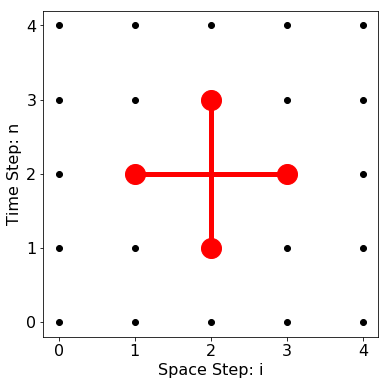

In [2]:
plt.figure(figsize=(6,6))
nx=ny=5
x = np.arange(nx)
y=np.zeros(ny)

for iy in range(nx):
    plt.plot(x,y,'ko')
    y+=1
plt.plot(1,2,'ro',ms=20)
plt.plot(3,2,'ro',ms=20)
plt.plot([1,3],[2,2],'r-',linewidth=5)
plt.plot(2,1,'ro',ms=20)
plt.plot(2,3,'ro',ms=20)
plt.plot([2,2],[1,3],'r-',linewidth=5)

plt.ylabel('Time Step: n',fontsize=16)
plt.yticks(range(5),fontsize=16)
plt.xlabel('Space Step: i',fontsize=16)
plt.xticks(range(5),fontsize=16)


plt.show()

**Figure 7-1. Example of a finite-difference stencil for the advection equation. **

The notation on the right-hand side of equation 14c is a bit cumbersome because one has to write out all of the spatial and temporal dependences.  Thus, there is great advantage in developing some sort of short form. In this case we can switch to index notation where **subscript indices** represent the spatial coordinate (usually the letter $i$) and **superscript indices** represent the temporal coordinate (usually using the letter $n$).  Thus, we can rewrite equation 14c as the following:

$$\begin{eqnarray}
\frac{\partial U(x,t)}{\partial x}+\frac{1}{c}\frac{\partial U(x,t)}{\partial t} &\approx &\frac{U(x+\Delta x,t)-U(x-\Delta x,t)}{2\Delta x} + \frac{U(x,t+\Delta t)-U(x,t-\Delta t)}{2c\Delta t} \\
&=& \frac{1}{2\Delta x}\left(U^n_{i+1}-U^n_{i-1}\right) + \frac{1}{2c\Delta t}\left(U^{n+1}_{i}-U^{n-1}_{i}\right), \tag{15a}
\end{eqnarray}$$

where in the figure above I have plotted the stencil for $[i,n]=[2,2]$.  

Note that compact notation easily can be extended to 2D (indicies $i,j$) or 3D (indicies $i,j,k$) spatial dimension scenarios using expressions like:

$$\begin{eqnarray}
\frac{\partial U(x,y,z,t)}{\partial x}+\frac{\partial U(x,y,z,t)}{\partial y}+\frac{\partial U(x,y,z,t)}{\partial z}+\frac{1}{c}\frac{\partial U(x,y,z,t)}{\partial t} 
\approx &&\\
\frac{1}{2\Delta x}\left(U^n_{i+1,j,k}-U^n_{i-1,j,k}\right) + \frac{1}{2\Delta y}\left(U^n_{i,j+1,k}-U^n_{i,j-1,k}\right)+ \frac{1}{2\Delta z}\left(U^n_{i,j,k+1}-U^n_{i,j,k-1}\right)+ \frac{1}{2c\Delta t}\left(U^{n+1}_{i,j,k}-U^{n-1}_{i,j,k}\right),&& \tag{15b}
\end{eqnarray} $$

which is much more compact that writing out all of the variable dependencies!

# Discretizing the 1D Advection Equation

One of the more straightforward PDEs to think about apply the above numerical derivative schemes to is the [advection equation](https://en.wikipedia.org/wiki/Advection).  This equation represents the transport of a substance or quantity by bulk motion. For example, the advection of pollutants or silt down a river. (Note that this is different than [convection](https://en.wikipedia.org/wiki/Convection) which combines advection with diffusion, which is a much more complex process to model.) 

The PDE governing advection of, say, a pollutant in a stream $U=U(x,t)$ is given by:

$$
\begin{eqnarray}
{\rm PDE:} & \quad & \frac{\partial U}{\partial x} = \frac{1}{c}\frac{\partial U}{\partial t}, \quad x\in[0,1], \quad t\in[0,1] \tag{16a}\\
{\rm Initial\, Condition:} & \quad & U(x,t=0)= e^{-(x-0.5)^2/\sigma^2}\tag{16b}\\
{\rm Boundary\, Conditions:} & \quad & U(x=0,t) = 0,  U(x=1,t) = 0\tag{16c}
\end{eqnarray}
$$

where $c$ is the speed of the material transport (e.g., rate of water flow).  Note that we are solving the advection problem on a solution domain $x\in[0,1]$ and $t\in[0,1]$ and have imposed initial condition such that $U(x,t=0)= e^{-(x-0.5)^2/10}$ and for the boundaries $U(x=0,t)=0$ and $U(x=1,t)=0$. 

## Analytic Solution

Let's first remind ourselves what the **general** solution to the PDE actually is (ignoring the boundary conditions for now). To obtain the solution we can follow the **separation of variables** approach.  First, assume that the general solution $U(x,t)$ may be represented as the product of two functions, one purely of space $X(x)$ and the other purely of time $T(t)$.  Thus, $U(x,t)=X(x)T(t)$.  Let's now put this into equation XX above to get:

$$ T X^\prime = \frac{1}{c} XT^\prime.$$

We can now rearrange the above to yields

$$\frac{X^\prime}{X} = \frac{T^\prime}{cT} = ik,$$

where the third equality represents the **separation constant**.  Let's now write the two equations of a single variable (and thus ODEs):

$$\begin{eqnarray}
X^\prime &=& ik X \\
T^\prime &=& ikc T \\
\end{eqnarray}$$

The solutions to these two equations are $X = Ae^{ikx}$ and $T=Be^{ikt/c}$ and thus the general solution is given by:

$$U(x,t) = Ce^{ik(x+ct)},$$

where I have used $C=AB$.  Thus, the interpretation of this analytic solution is that the **initial solution should travel to the left or right** (depending on whether $c$ is positive or negative), but it **should not change shape**.  To get the actual exact solution that satisfies all the initial and boundary conditions would require superimposing different Fourier solutions weighted by the difference coefficients $C_n$; however, this discussion goes beyond the scope of the current presentation.

## Numerical Solutions

Let's now say that we are looking to solve this equation numerically on a "grid" or "mesh".  In this case we have to choose our **discretization interval**, which effectively is how we sample our numerical solution grid in space and time.  Let's say that we choose $\Delta t = 0.04$ s and $\Delta x = 0.04$ m as our time and space discretization intervals. Since our domains are defined by $x\in[0,1]$ and $t\in[0,1]$, this means that we have $I \times N=26 \times 26$ grid points in our numerical solution.

To illustrate what the solution grids looks like, I plot a graphical representation of it in the figure below. Here, I've plotted two different colors.  The green circles are those points on the solution grid where we already know the solution (i.e., because of the initial and boundary conditions).  The black circles are those points in the solution domain where the solution is unknown. Thus, the goal of computing the finite-difference solution of the PDE is to use the information that is currently defined on the green points to calculate quantities on the black points.

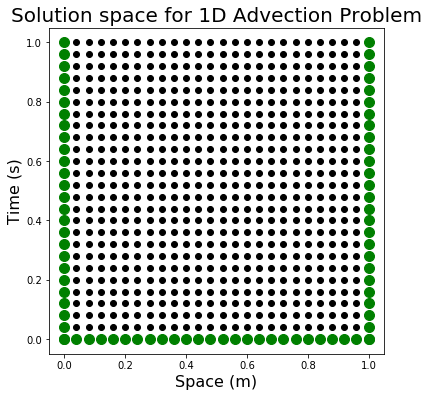

In [3]:
plt.figure(figsize=(6,6))
nx=ny=26
x = np.arange(nx)/(nx-1)
y=np.zeros(ny)

for iy in range(nx):
    plt.plot(x,y,'ko')
    y+=1/(nx-1)
plt.plot(x,np.zeros(ny),'go',ms=10)
plt.plot(np.zeros(ny),x,'go',ms=10)
plt.plot(np.zeros(ny)+1,x,'go',ms=10)    
plt.ylabel('Time (s)',fontsize=16)
plt.xlabel('Space (m)',fontsize=16)
plt.title('Solution space for 1D Advection Problem',fontsize=20)
plt.show()

**Figure 7-2. Solution domain $D$ for the advection equation at discete solution points $u_{i}^n$. The black dots represent locations where the solution is not known.  The green dots are the locations where the solution is known because of the initial and boundary conditions.**

### Solution by *explicit* FTCS method

Let's now think about how we are going to discretize the partial deriatives in equation 16a.  We'll start with what a Forward in Time and Centered in Space (or FTCS) method.  To compute such a solution we need to use a **first-order forward difference** in time at each spatial grid point $i$:

$$\frac{\partial U}{\partial t} \approx \frac{U^{n+1}_i - U^{n}_i}{\Delta t}, \tag{17a}$$

and then use a **second-order centered difference** in space at each temporal grid point $n$:

$$\frac{\partial U}{\partial x} \approx \frac{U^{n}_{i+1} - U^{n}_{i-1}}{2\Delta x}. \tag{17b}$$

We can now use these approximations to generate a **finite-difference stencil** representing the 1D advection PDE in equation 16a 

$$\frac{U^{n}_{i+1} - U^{n}_{i-1}}{2\Delta x} = \frac{1}{c}\left(\frac{U^{n+1}_i - U^{n}_i}{\Delta t} \right), \tag{17c}$$

that is first-order accurate in time and second-order accurate in space. A compact way to write this level of accuracy is $\mathcal{O}\left(\Delta t, \Delta x^2  \right)$.

If, for a moment, we assume that $n=0$, we see that we know all of the quantities in equation 17c - except for the value of $U^{n+1}_{i}$.  Thus, let's rearrange equation 17c where all of the unknown terms at time points $n+1$ are on the left and all the known terms at time points $n$ are on the right:

$$U^{n+1}_i  =\frac{c\Delta t}{2\Delta x}\left(U^{n}_{i+1} - U^{n}_{i-1}\right) + U^{n}_i, \tag{17d}$$

or if we define $\gamma_{FTCS} = \frac{c\Delta t}{2\Delta x}$, then we have:

$$U^{n+1}_i  =\gamma_{FTCS} \left(U^{n}_{i+1} - U^{n}_{i-1}\right) + U^{n}_i, \tag{17d}$$

Because the only unknown grid point is **explictly** defined by all of the other points, this type of approach is called an **explict finite-difference solution.** Graphically, this stencil centered about $[i,n]=[2,2]$ looks like the following:

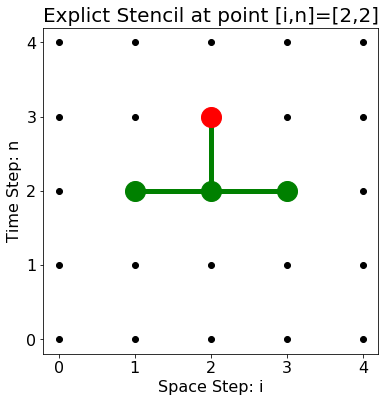

In [4]:
plt.figure(figsize=(6,6))
nx=ny=5
x = np.arange(nx)
y=np.zeros(ny)

for iy in range(nx):
    plt.plot(x,y,'ko')
    y+=1
    
# . . Solution at point i
plt.plot(1,2,'go',ms=20)
plt.plot(3,2,'go',ms=20)
plt.plot([1,3],[2,2],'g-',linewidth=5)
plt.plot(2,2,'go',ms=20)
plt.plot([2,2],[2,3],'g-',linewidth=5)
plt.plot(2,3,'ro',ms=20)

plt.ylabel('Time Step: n',fontsize=16)
plt.yticks(range(5),fontsize=16)
plt.xlabel('Space Step: i',fontsize=16)
plt.xticks(range(5),fontsize=16)

plt.title('Explict Stencil at point [i,n]=[2,2]',fontsize=20)
plt.show()

**Figure 7-3. Explicit stencil for a FTSC solution of the advection equation.  Known points are given in green while the unknown point is in red.**

where the known values in green are used to calculate the single unknown value in red.  In the above figure I have simply chosen a value of $[i,n]=[2,2]$; however, this **stencil** is also applicable to all of the other points in the grid.  For example, one can think of stencils at neighbouring points  $[i,n]=[1,2]$ and  $[i,n]=[3,2]$ to be very similar!

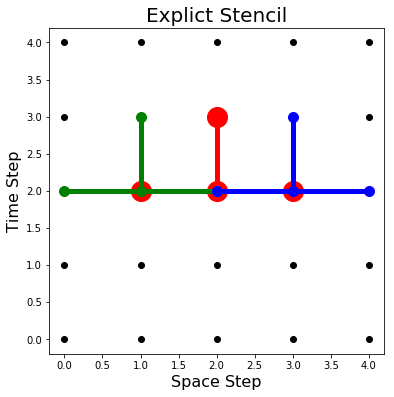

In [5]:
plt.figure(figsize=(6,6))
nx=ny=5
x = np.arange(nx)
y=np.zeros(ny)

for iy in range(nx):
    plt.plot(x,y,'ko')
    y+=1
    
# . . Solution at point i
plt.plot(1,2,'ro',ms=20)
plt.plot(3,2,'ro',ms=20)
plt.plot([1,3],[2,2],'r-',linewidth=5)
plt.plot(2,2,'ro',ms=20)
plt.plot(2,3,'ro',ms=20)
plt.plot([2,2],[2,3],'r-',linewidth=5)

# . . Solution at point i-1
plt.plot(0,2,'go',ms=10)
plt.plot(2,2,'go',ms=10)
plt.plot([0,2],[2,2],'g-',linewidth=5)
plt.plot(1,2,'go',ms=10)
plt.plot(1,3,'go',ms=10)
plt.plot([1,1],[2,3],'g-',linewidth=5)

# . . Solution at point i+1
plt.plot(2,2,'bo',ms=10)
plt.plot(4,2,'bo',ms=10)
plt.plot([2,4],[2,2],'b-',linewidth=5)
plt.plot(3,2,'bo',ms=10)
plt.plot(3,3,'bo',ms=10)
plt.plot([3,3],[2,3],'b-',linewidth=5)

plt.ylabel('Time Step',fontsize=16)
plt.xlabel('Space Step',fontsize=16)
plt.title('Explict Stencil',fontsize=20)
plt.show()

**Figure 7-4. Illustration of a stencil.  The green and blue stencils are identical to the red one, except that they are shifted the the left and right by one grid point.**

In fact, this is why it is called a **stencil**: you can move it around the computational mesh, but the shape doesn't change!

Let's now look at a numerical solution. Here, I using a solution grid of $x\in [0,1]$ that is discretized by $nx=101$ points with a spacing of $dx=0.01$. The velocity has been set at $c=1$

In [6]:
## . . Time axis parametes
nt,dt=101,0.01

## . . Space axis parameters
xmin,xmax=0,1
nx=101
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition
sigma=0.1
midpoint = (xmax-xmin)/2
Un = np.zeros(np.size(xx))
Un = np.exp(-(xx-midpoint)**2/sigma**2)

## . . FD paramters
c = 1 # velocity
gamma_FTCS = c*dt/(2*dx)

Uleft = Uright = 0 # Boundary conditions on left and right

fig = plt.figure()
fig.set_dpi(100)
ax1 = fig.add_subplot(1,1,1)

## . . Advection equation solution
def Advection_Solution(Un):
    Un[1:nx-1] = gamma_FTCS*(Un[2:nx]-Un[0:nx-2])+Un[1:nx-1] # . . Writes over itself
    Un[0     ] = Uleft  # . . Enforce left  boundary condition
    Un[nx-1  ] = Uright # . . Enforce right boundary condition
    return Un

c = np.zeros((nx,nt))
for i in range(nt):
    value = Advection_Solution(Un)
    Un = value
    c[:,i]=Un
    
k = 0
def advection_animate(i):
    global k
    x = c[:,k]
    k += 1
    ax1.clear()
    plt.plot(xx,x,color='cyan')
    plt.grid(True)
    plt.xlim([xmin,xmax])
    plt.ylim([-1.5,1.5])
    
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig,advection_animate,frames=nt-2,interval=50)

In [7]:
HTML(anim.to_html5_video())

**Figure 7-5. FTSC solution of the advection equation for a left-going wave. Note that this because unstable as the wave disturbance progresses toward the boundary.**

This is evidently not the solution that we're looking for! While we do see that there is a left-going wave, there appears to be some strong **numerical instability** that makes this solution approach look undesirable.  Let's now run it again with a negative velocity.

In [8]:
## . . Time axis parametes
nt,dt=101,0.01

## . . Space axis parameters
xmin,xmax=0,1
nx=101
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition
sigma=0.1
midpoint = (xmax-xmin)/2
Un = np.zeros(np.size(xx))
Un = np.exp(-(xx-midpoint)**2/sigma**2)

## . . FD paramters
c = -1 # velocity
gamma_FTCS = c*dt/(2*dx)

Uleft = Uright = 0 # Boundary conditions on left and right

fig = plt.figure()
fig.set_dpi(100)
ax1 = fig.add_subplot(1,1,1)

## . . Advection equation solution
def Advection_Solution(Un):
    Un[1:nx-1] = gamma_FTCS*(Un[2:nx]-Un[0:nx-2])+Un[1:nx-1] # . . Writes over itself
    Un[0     ] = Uleft  # . . Enforce left  boundary condition
    Un[nx-1  ] = Uright # . . Enforce right boundary condition
    return Un

c = np.zeros((nx,nt))
for i in range(nt):
    value = Advection_Solution(Un)
    Un = value
    c[:,i]=Un
    
k = 0
def advection_animate(i):
    global k
    x = c[:,k]
    k += 1
    ax1.clear()
    plt.plot(xx,x,color='cyan')
    plt.grid(True)
    plt.xlim([xmin,xmax])
    plt.ylim([-1.5,1.5])
    
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig,advection_animate,frames=nt-2,interval=50)

In [9]:
HTML(anim.to_html5_video())

**Figure 7-6. FTSC solution of the advection equation for a right-going wave. Note that this because unstable as the wave disturbance progresses toward the boundary.**

While we now have a right-going wave, it again exhibits the same time of instability.  Let's explore why this might be happening

### Von Neumann Stability Analysis

In numerical analysis, the von Neumann stability analysis method can be used to examine the **conditions for stability** for linear PDEs.  The main idea is that we want to ensure that the difference between the true and numerical solution - that is the **numerical error** $\epsilon_n$ (where $n$ is the nth time step of solution) - does not grow exponentially in time.  In particular, one wants to ensure that the ratio of the absolute error squared (a measure of **energy**) at time step $n+1$ to that at $n$ is less than one:

$$g^2=\frac{|\epsilon_{n+1}|^2}{|\epsilon_n|^2} < 1, \tag{18}$$

where $g$ is known as the **amplication factor**.  

Let's first say that the error term satisfies the discretization itself such that:

$$\epsilon^{n+1}_i = \epsilon^n_i+\frac{c \Delta t}{2\Delta x}\left(\epsilon^n_{i+1}-\epsilon^n_{i-1}\right) \tag{19}$$

The main argument is that one can represent the spatial component of the error term by a Fourier Series

$$\epsilon(x) = \sum_m^\infty A_m e^{ik_m x} \tag{20}$$

where $k_m$ is a wavenumber.  Now, because the error terms tend to exponentially grow or decay over time, it is reasonably to include the temporal component as $e^{at}$ such that a general form of the error term can be written as:

$$\epsilon(x,t) = \sum_{m=0}^\infty A_m e^{at} e^{ik_m x}. \tag{21}$$

Let's now examine any particular term 

$$\epsilon_m(x,t) = e^{at} e^{ik_m x}.\tag{22}$$

Thus, we can assume that 

$$\begin{eqnarray}
\epsilon^n_i &=& e^{at} e^{ik_m x}\tag{23a} \\
\epsilon^{n+1}_i &=& e^{a(t+\Delta t)} e^{ik_m x} \tag{23b}\\
\epsilon^n_{i+1} &=& e^{at} e^{ik_m (x+\Delta x)} \tag{23c}\\
\epsilon^n_{i-1} &=& e^{at} e^{ik_m (x-\Delta x)} \tag{23d}\\
\end{eqnarray}$$

Inserting these back into equation 19 yields the error at the $n+1$ term:

$$ e^{a(t+\Delta t)} e^{ik_m x} =e^{at} e^{ik_m x} + \frac{c \Delta t}{2\Delta x} 
\left(e^{at}e^{ik_m (x+\Delta x)}-e^{at} e^{ik_m (x-\Delta x)}\right). \tag{24}$$

Dividing both sides of equation 24 by the error at the $n$ term (i.e., $e^{at}e^{ik_m x}$) yields:

$$ g = \frac{\epsilon_{n+1}}{\epsilon_n} = 1+ e^{a\Delta t} = \frac{c \Delta t}{2\Delta x}
\left(e^{ik_m \Delta x} - e^{-ik_m \Delta x}\right) . \tag{25}$$

Using Euler expression $\sin \theta = \frac{e^{i\theta}-e^{-i\theta}}{2i}$ allow us to write

$$ g = \frac{\epsilon_{n+1}}{\epsilon_n} = e^{a\Delta t} = \frac{ic \Delta t}{\Delta x}
\sin (k_m \Delta x) +1 . \tag{25}$$

Let's now compute $g^2 = \overline{g}g$ (where the the overline indicates complex conjugate):

$$|g|^2 = g^*g = \overline{\left(\frac{ic \Delta t}{\Delta x}
\sin (k_m \Delta x) +1\right)} \left(\frac{ic \Delta t}{\Delta x}
\sin (k_m \Delta x) +1\right) = 1+\frac{c^2 \Delta t^2}{\Delta x^2}\sin^2(k_m\Delta x). \tag{26}$$

Thus, we see that unless our time step $\Delta t=0$ or spatial sampling is $\Delta x\rightarrow \infty$, there is no way to satisfy $|g|^2<1$ and thus this solution approach is **unconditionally unstable**.

## Solution by *Upwind* Method

Let's now modestly adapt our numerical solution approach by changing up our spatial discritization.  Assuming that $c>0$, instead of looking both to the left and the right in a centered spatial scheme, let's look at a finite-difference scheme given by:

$$\frac{U^{n}_{i+1} - U^{n}_{i}}{\Delta x} = \frac{1}{c}\left(\frac{U^{n+1}_i - U^{n}_i}{\Delta t} \right), \tag{27}$$

where we now compute a first-order accurate spatial derivative.  Rearranging the terms to isolate the $n+1$ term gives us:


$$U^{n+1}_i  =  U^{n}_i + \frac{c\Delta t}{\Delta x}\left(U^{n}_{i+1} - U^{n}_{i}\right), \tag{28}$$

Let's now look at how our numerical solution changes.  I'm using the same parameters as before; however, I've just slightly changed the numerical scheme.

In [10]:
## . . Time axis parametes
nt,dt=101,0.01

## . . Space axis parameters
xmin,xmax=0,1
nx=101
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition
sigma=0.1
midpoint = (xmax-xmin)/2
Un = np.zeros(np.size(xx))
Un = np.exp(-(xx-midpoint)**2/sigma**2)

## . . FD paramters
c = 0.5 # velocity
gamma_upwind = c*dt/dx

Uleft = Uright = 0 # Boundary conditions on left and right

fig = plt.figure()
fig.set_dpi(100)
ax1 = fig.add_subplot(1,1,1)

## . . Advection equation solution
def Advection_Solution(Un):
    Un[1:nx-1] = gamma_upwind*(Un[2:nx]-Un[1:nx-1])+Un[1:nx-1] # . . Writes over itself
    Un[0     ] = Uleft  # . . Enforce left  boundary condition
    Un[nx-1  ] = Uright # . . Enforce right boundary condition
    return Un

c = np.zeros((nx,nt))
for i in range(nt):
    value = Advection_Solution(Un)
    Un = value
    c[:,i]=Un
    
k = 0
def advection_animate(i):
    global k
    x = c[:,k]
    k += 1
    ax1.clear()
    plt.plot(xx,x,color='cyan')
    plt.grid(True)
    plt.xlim([xmin,xmax])
    plt.ylim([-0.1,1.1])
    
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig,advection_animate,frames=nt-2,interval=50)

In [11]:
HTML(anim.to_html5_video())

**Figure 7-7. Upwind solution of the advection equation for a left-going wave. While this approachr is now stable as the wave disturbance progresses toward the boundary, it loses amplitude and spreads out indicating that the solution is dispesive.**

This is an interesting result because the solution is now **stable**; however, the amplitude of the solution is changing and appears to be broadening.  This is because this solution is experiencing **numerical dispersion**, which means that the different wavenumber (or frequency) components are traveling with a different velocity = $c=c(\lambda)$.  This is a ubiquitous issue in numerical solutions of PDEs, which we will discuss below.

Another question worth discussing is whether or not we have actually solved the stability problem.  To answer this, let's look at what happens if we use this same numerical scheme but with a **negative velocity**.

In [12]:
## . . Time axis parametes
nt,dt=101,0.01

## . . Space axis parameters
xmin,xmax=0,1
nx=101
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition
sigma=0.1
midpoint = (xmax-xmin)/2
Un = np.zeros(np.size(xx))
Un = np.exp(-(xx-midpoint)**2/sigma**2)

## . . FD paramters
c = -1 # velocity
gamma_upwind = c*dt/dx

Uleft = Uright = 0 # Boundary conditions on left and right

fig = plt.figure()
fig.set_dpi(100)
ax1 = fig.add_subplot(1,1,1)

## . . Advection equation solution
def Advection_Solution(Un):
    Un[1:nx-1] = gamma_upwind*(Un[2:nx]-Un[1:nx-1])+Un[1:nx-1] # . . Writes over itself
    Un[0     ] = Uleft  # . . Enforce left  boundary condition
    Un[nx-1  ] = Uright # . . Enforce right boundary condition
    return Un

c = np.zeros((nx,nt))
for i in range(nt):
    value = Advection_Solution(Un)
    Un = value
    c[:,i]=Un
    
k = 0
def advection_animate(i):
    global k
    x = c[:,k]
    k += 1
    ax1.clear()
    plt.plot(xx,x,color='cyan')
    plt.grid(True)
    plt.xlim([xmin,xmax])
    plt.ylim([-1.5,1.5])
    
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig,advection_animate,frames=nt-2,interval=50)

In [13]:
HTML(anim.to_html5_video())

**Figure 7-8. Upwind solution of the advection equation for a right-going wave. Note that this is an unstable solution - even though the left-going propagation was stable.**

Obviously, not the solution we want. Let's take a look at the von Neumann stability analysis:

$$\epsilon^{n+1}_i = \epsilon^n_i+\frac{c \Delta t}{\Delta x}\left(\epsilon^n_{i+1}-\epsilon^n_i\right) \tag{19}$$

where we agin use the following terms:

$$\begin{eqnarray}
\epsilon^n_i &=& e^{at} e^{ik_m x}\tag{23a} \\
\epsilon^{n+1}_i &=& e^{a(t+\Delta t)} e^{ik_m x} \tag{23b}\\
\epsilon^n_{i+1} &=& e^{at} e^{ik_m (x+\Delta x)} \tag{23c}\\
\end{eqnarray}$$

Inserting these back into equation 19 yields the error at the $n+1$ term:

$$ e^{a(t+\Delta t)} e^{ik_m x} =e^{at} e^{ik_m x} + \frac{c \Delta t}{2\Delta x} 
\left(e^{at}e^{ik_m (x+\Delta x)}-e^{at} e^{ik_m x}\right). \tag{24}$$

Dividing both sides of equation 24 by the error at the $n$ term (i.e., $e^{at}e^{ik_m x}$) yields:

$$ g = \frac{\epsilon_{n+1}}{\epsilon_n} = e^{a\Delta t} = 1-\frac{c \Delta t}{\Delta x}\left(1-e^{ik_m \Delta x}\right) . \tag{25}$$

or if $\gamma = \frac{c \Delta t}{\Delta x}$ and $\phi =k \Delta x$ then 

$$ g = \frac{\epsilon_{n+1}}{\epsilon_n} = e^{a\Delta t} = 1-\gamma +\gamma e^{i\phi} . \tag{25}$$

Let's now compute the stability condition $|g|^2$:

$$|g|^2 = 1+2(\gamma-1)\gamma-2(\gamma-1)\gamma \cos(\phi) <1 \tag{26}$$

which requires the following for stability

$$ 2(\gamma-1)\gamma-2(\gamma-1)\gamma \cos(\phi) <0 \tag{26}$$

or 

$$ 2(\gamma-1)\gamma(1-\cos(\phi)) <0. \tag{26}$$

When $\phi=-\pi$, we have the greatest value of $(1-\cos(\phi))=2$.  Thus, let's write the following as a necessary condition:

$$ 2(\gamma-1)\gamma 2  <0. \tag{26}$$

Thus, the only way that this can be always true is if $\gamma\le 1$ or:

$$\frac{c\Delta t}{\Delta x} \le 1. $$

This implies that 

$$c \le \frac{\Delta x}{\Delta t}. $$

That is, the **upwind method** is **conditionally stable**, i.e., is stable if and only if the **physical** velocity $c$ is not bigger than the **spreading velocity** $\Delta x/ \Delta t$ of the numerical method. This is equivalent to the condition that the time step, $\Delta t$, must be smaller than the time taken for the wave to travel the distance of the spatial step, $\Delta x$. This condition is called a Courant-Friedrichs-Lewy (CFL) stability criterion, and is named after R. Courant, K. Friedrichs, and H.
Lewy, who described it in their foundational paper in 1928.

### *Downwind* Solutions

Let's now look at changing up the solution so that instead of looking **upwind**, we are now looking **downwind**.  That is, we are considering spatial points behind our current location.

$$\frac{U^{n}_{i} - U^{n}_{i-1}}{\Delta x} = \frac{1}{c}\left(\frac{U^{n+1}_i - U^{n}_i}{\Delta t} \right), \tag{27}$$

where we now compute a first-order accurate spatial derivative.  Rearranging the terms to isolate the $n+1$ term gives us:


$$U^{n+1}_i  =  U^{n}_i + \frac{c\Delta t}{\Delta x}\left(U^{n}_{i} - U^{n}_{i-1}\right), \tag{28}$$

Let's now look at how our numerical solution changes.  I'm using the same parameters as before; however, I've just slightly changed the numerical scheme.

In [14]:
## . . Time axis parametes
nt,dt=101,0.01

## . . Space axis parameters
xmin,xmax=0,1
nx=101
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition
sigma=0.1
midpoint = (xmax-xmin)/2
Un = np.zeros(np.size(xx))
Un = np.exp(-(xx-midpoint)**2/sigma**2)

## . . FD paramters
c = -1 # velocity
gamma_upwind = c*dt/dx

Uleft = Uright = 0 # Boundary conditions on left and right

fig = plt.figure()
fig.set_dpi(100)
ax1 = fig.add_subplot(1,1,1)

## . . Advection equation solution
def Advection_Solution(Un):
    Un[1:nx-1] = gamma_upwind*(Un[1:nx-1]-Un[0:nx-2])+Un[1:nx-1] # . . Writes over itself
    Un[0     ] = Uleft  # . . Enforce left  boundary condition
    Un[nx-1  ] = Uright # . . Enforce right boundary condition
    return Un

c = np.zeros((nx,nt))
for i in range(nt):
    value = Advection_Solution(Un)
    Un = value
    c[:,i]=Un
    
k = 0
def advection_animate(i):
    global k
    x = c[:,k]
    k += 1
    ax1.clear()
    plt.plot(xx,x,color='cyan')
    plt.grid(True)
    plt.xlim([xmin,xmax])
    plt.ylim([-1.5,1.5])
    
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig,advection_animate,frames=nt-2,interval=50)

In [15]:
HTML(anim.to_html5_video())

**Figure 7-9. Downwind solution of the advection equation for a right-going wave. Note that this is a stable solution - and appears to be dispesion free.**

### A Linear Algebra Framework

The shifting stencils in figure above actually are a **system of linear equations** that can be represented in a straightforward manner using matrix algebra in the form of ${\bf Ax}={\bf b}$ where ${\bf m}$ is the vector of $I$ unknown values $U^{n+1}_i$ on the left-hand side of equation 17d, ${\bf b}$ is a vector of $I$ known values on the right-hand side of equation 17d, and ${\bf A}$ is a matrix that represents the mapping between ${\bf m}$ and ${\bf d}$.  Let's write this out explicitly:

$${\bf Ax} = {\bf b} \tag{29}$$

which corresponds to

$$
\left[
\begin{array}{ccccccc}
1 & 0 & 0 & ... & 0 &0 &0 \\
0 & 1 & 0 & ... & 0 &0 &0 \\
0 & 0 & 1 & ... & 0 &0 &0 \\
\vdots & \vdots & \vdots & \ddots & \vdots &\vdots &\vdots \\
0 &0&0&...&1&0&0\\
0 &0&0&...&0&1&0\\
0 &0&0&...&0&0&1\\
\end{array}
\right]
\left[
\begin{array}{c}
U^{n+1}_0 \\
U^{n+1}_1 \\
U^{n+1}_2 \\
\vdots\\
U^{n+1}_{I-2} \\
U^{n+1}_{I-1} \\
U^{n+1}_{I} \\
\end{array}
\right]
=
\left[
\begin{array}{c}
\gamma \left(U^{n}_{1} - U^{n}_{0}\right) + U^{n}_{0} \\
\gamma \left(U^{n}_{2} - U^{n}_{1}\right) + U^{n}_{1} \\
\gamma \left(U^{n}_{3} - U^{n}_{2}\right) + U^{n}_{2} \\
\vdots\\
\gamma \left(U^{n}_{I-2} - U^{n-3}_{I-3}\right) + U^{n}_{I-2} \\
\gamma \left(U^{n}_{I-1} - U^{n-2}_{I-1}\right) + U^{n}_{I-1} \\
\gamma \left(U^{n}_{I  } - U^{n-1}_{I  }\right) + U^{n}_{I} \\
\end{array}
\right]. \tag{30}
$$

Note: clearly, this is kind of a boring equation because ${\bf A=I}$ is really an identity matrix that is not explictly needed in this context; however, I'm including it for parallelism with the sections below.

## Lax-Wendroff Method

The Lax-Wendroff method is a more accurate approach for solving the advection equation using a **multi-step** approach.  In these type of approaches, one first calculates two quantity at the **half step** $U^{n+\frac{1}{2}}$ and then uses these quantity to generate the solution at the full step $U^{n+1}$. This approach is illustrated in the figure below where one uses the three point at time level $n=2$ to calculate two solutions at time level $n=2+\frac{1}{2}$ (dotted lines) and then combines these approaches to calculate the solution at one point at time step $n=3$.

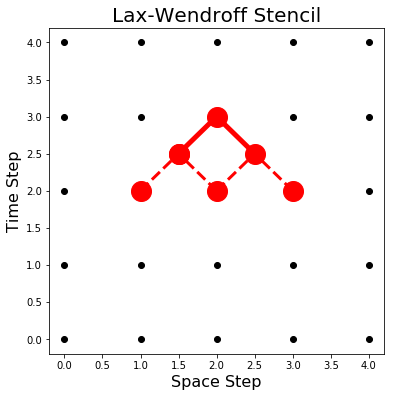

In [24]:
plt.figure(figsize=(6,6))
nx=ny=5
x = np.arange(nx)
y=np.zeros(ny)

for iy in range(nx):
    plt.plot(x,y,'ko')
    y+=1
   
# . . Solution at point i-1
plt.plot(1,2,    'ro',ms=20)
plt.plot(1.5,2.5,'ro',ms=20)
plt.plot(2,2,    'ro',ms=20)
plt.plot([2,1.5],[3,2.5],'r-',linewidth=5)
plt.plot([2.5,2],[2.5,3],'r-',linewidth=5)

# . . Solution at point i
plt.plot(1.5,2.5,'ro',ms=20)
plt.plot(2.5,2.5,'ro',ms=20)
plt.plot(2,3,    'ro',ms=20)
plt.plot(3,2,    'ro',ms=20)
plt.plot([2,1.5],[2,2.5],'r--',linewidth=3)
plt.plot([1,1.5],[2,2.5],'r--',linewidth=3)
plt.plot([2,2.5],[2,2.5],'r--',linewidth=3)
plt.plot([3,2.5],[2,2.5],'r--',linewidth=3)

plt.ylabel('Time Step',fontsize=16)
plt.xlabel('Space Step',fontsize=16)
plt.title('Lax-Wendroff Stencil',fontsize=20)
plt.show()

**Figure 7-10. Illustration of the Lax-Wendroff two-step solution grid. Here, one first approximates solutions at the half step (here $n=2.5$) that are then used to calculate the solution at the full step (here $n=3$).**

For the 1D advection equation, this means solving the following two-step scheme:

$$u^{n+1/2}_{i-1/2} = \frac{1}{2} \left( u^n_i +u^n_{i-1} 
\right) -  \frac{c\Delta t}{2\Delta x} \left( u^n_i-u^n_{i-1}\right) \tag{32a}$$
$$u^{n+1/2}_{i+1/2} = \frac{1}{2} \left( u^n_i +u^n_{i+1} 
\right) -  \frac{c\Delta t}{2\Delta x} \left( u^n_{i+1}-u^n_i\right) \tag{32b}$$
$$u^{n+1}_{i} = u^n_i -  \frac{c\Delta t}{\Delta x} \left(u^{n+1/2}_{i+1/2}-u^{n+1/2}_{i-1/2}\right) \tag{32c}$$

However, by backsubstituting equations 32a and 32b into equation 32c, this scheme can be rewritten as

$$u^{n+1}_{i} = b_{-1}u^{n}_{i-1}+b_{0}u^{n}_{i}+b_{+1}u^{n}_{i+1} \tag{33a}$$

where

$$b_{-1} = \frac{\alpha}{2}\left(\alpha+1\right)  \tag{33b}$$
$$b_{ 0} = 1-\alpha^2  \tag{33c}$$
$$b_{+1} = \frac{\alpha}{2}\left(\alpha-1\right)  \tag{33d}$$

and $\alpha=\frac{c\Delta t}{\Delta x}$ is the **Courant number**.

In [25]:
## . . Time axis parametes
nt,dt=101,0.01

## . . Space axis parameters
xmin,xmax=0,1
nx=101
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition
sigma=0.1
midpoint = (xmax-xmin)/2
Un = np.zeros(np.size(xx))
Up = np.zeros(np.size(xx))
Un = np.exp(-(xx-midpoint)**2/sigma**2)
Up = np.exp(-(xx-midpoint)**2/sigma**2)

## . . FD paramters
vel= 1 # velocity
alpha = vel*dt/dx

Uleft = Uright = 0 # Boundary conditions on left and right

fig = plt.figure()
fig.set_dpi(100)
ax1 = fig.add_subplot(1,1,1)

## . . L-W coefficients (positive)
bm = alpha/2*(alpha+1)
b0 = 1-alpha**2
bp = alpha/2*(alpha-1)

## . . L-W coefficients (negative)
alpha = -alpha
bbm = alpha/2*(alpha+1)
bb0 = 1-alpha**2
bbp = alpha/2*(alpha-1)

## . . Advection equation solution
def Lax_Wendroff_Solution_neg(Un):
    Un[1:nx-1] = bm*Un[0:nx-2]+b0*Un[1:nx-1]+bp*Un[2:nx] 
    Un[0     ] = Uleft  # . . Enforce left  boundary condition
    Un[nx-1  ] = Uright # . . Enforce right boundary condition
    return Un

## . . Advection equation solution
def Lax_Wendroff_Solution_pos(Un):
    Up[1:nx-1] = bbm*Un[0:nx-2]+bb0*Up[1:nx-1]+bbp*Up[2:nx] 
    Up[0     ] = Uleft  # . . Enforce left  boundary condition
    Up[nx-1  ] = Uright # . . Enforce right boundary condition
    return Up

c = np.zeros((nx,nt))
d = np.zeros((nx,nt))

for i in range(nt):
    value = Lax_Wendroff_Solution_neg(Un)
    Un = value
    c[:,i]=Un
    value = Lax_Wendroff_Solution_pos(Up)
    Up = value
    d[:,i]=Up
    
k = 0
def advection_animate(i):
    global k
    x = c[:,k]
    y = d[:,k]
    k += 1
    ax1.clear()
    plt.plot(xx,x,'c',xx,y,'m')
    plt.grid(True)
    plt.xlim([xmin,xmax])
    plt.ylim([-1.5,1.5])
    
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig,advection_animate,frames=nt-2,interval=50)

In [18]:
HTML(anim.to_html5_video())

**Figure 7-11. Illustration of the Lax-Wendroff two-step solution. I have plotted both the left- (magenta) and right-going (cyan) solutions that are both stable and largely dispersion-free.**

Where we now see that we have stable and (largely) dispersion free. Note also that this scheme has an accuracy order of $O(\Delta x^2,\Delta ^2)$.  A further interesting observation is that this equation is equivalent to the following advection+diffusion equation:

$$\frac{\partial u}{\partial t} = -c \frac{\partial u}{\partial x}+D \frac{\partial^2 u}{\partial x^2}, \tag{34a}$$

where $D$ is an effective diffusion term given by:

$$D = \frac{\Delta x^2}{2\Delta t}- c^2\frac{\Delta t}{2}. \tag{34b}$$

### A Linear Algebra Framework

The shifting stencils in figure again are a **system of linear equations** that can be represented in a straightforward manner using matrix algebra in the form of ${\bf Ax}={\bf Rb}$ where ${\bf m}$ is the vector of $I$ unknown values $U^{n+1}_i$ on the left-hand side of equation 17d, ${\bf b}$ is a vector of $I$ known values on the right-hand side of equation 17d, and ${\bf A}$ and ${\bf R}$ are two matrix operators that define the mapping between ${\bf m}$ and ${\bf d}$.  Let's write this out explicitly:

$${\bf Ax} = {\bf Rb} \tag{35}$$

which corresponds to

$$
\left[
\begin{array}{ccccccc}
1 & 0 & 0 & 0 & ... & 0& 0 &0 &0 \\
0 & 1 & 0 & 0 & ... & 0& 0 &0 &0 \\
0 & 0 & 1 & 0 & ... & 0& 0 &0 &0 \\
\vdots & \vdots & \vdots & \ddots & \vdots &\vdots &\vdots \\
0 &0&0& 0 &...& 0&1&0&0\\
0 &0&0& 0 &...& 0&0&1&0\\
0 &0&0& 0 &...& 0&0&0&1\\
\end{array}
\right]
\left[
\begin{array}{c}
U^{n+1}_0 \\
U^{n+1}_1 \\
U^{n+1}_2 \\
\vdots\\
U^{n+1}_{I-2} \\
U^{n+1}_{I-1} \\
U^{n+1}_{I} \\
\end{array}
\right]
=
\left[
\begin{array}{ccccccc}
b_0 & b_{+1} & 0 & 0&... &0& 0 &0 &0 \\
b_{-1} & b_0 & b_{+1} & 0& ... &0& 0 &0 &0 \\
0 & b_{-1} & b_0 & b_{+1} &... &0& 0 &0 &0 \\
\vdots & \vdots & \vdots & \ddots & \vdots &\vdots &\vdots \\
0 &0&0&0&...& b_{-1}&b_0&b_{+1}&0\\
0 &0&0&0&...&0 &b_{-1}&b_0&b_{+1}\\
0 &0&0&0&...&0 &0&b_{-1}&b_0\\
\end{array}
\right]
\left[
\begin{array}{c}
 U^{n}_{0} \\
 U^{n}_{1} \\
U^{n}_{2} \\
\vdots\\
U^{n}_{I-2} \\
U^{n}_{I-1} \\
 U^{n}_{I} \\
\end{array}
\right]. \tag{36}$$

## A few thoughts on Boundary Conditions

One thing that we didn't fully cover above is the boundary condition.  Note that I have set these to be $u(0)=u(1)=0$ in the above. However, these can easily be changed. 

### Neumann Boundary Conditions

Let's say we wanted to include the following Neumann BC

$$\left.\frac{\partial u }{\partial x} = 0  \right|_{x=1} \tag{37a}$$

In this case, we can use the following approximation:

$$\frac{U^i_{nx}- U^i_{nx-1}}{\Delta x} = 0 \tag{37b}$$ 

or rearranging terms

$$ U^i_{nx}= U^i_{nx-1} \tag{37b}$$ 

which is straightforward to implement.

In [19]:
## . . Time axis parametes
nt,dt=101,0.01

## . . Space axis parameters
xmin,xmax=0,1
nx=101
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition
sigma=0.1
midpoint = (xmax-xmin)/2
Un = np.zeros(np.size(xx))
Un = np.exp(-(xx-midpoint)**2/sigma**2)

## . . FD paramters
vel= 1 # velocity
alpha = vel*dt/dx

fig = plt.figure()
fig.set_dpi(100)
ax1 = fig.add_subplot(1,1,1)

## . . L-W coefficients (positive)
bm = alpha/2*(alpha+1)
b0 = 1-alpha**2
bp = alpha/2*(alpha-1)

## . . Advection equation solution
def Lax_Wendroff_Solution_neg(Un):
    Un[1:nx-1] = bm*Un[0:nx-2]+b0*Un[1:nx-1]+bp*Un[2:nx] 
    Un[0     ] = Un[1  ]  # . . Enforce left  boundary condition
    Un[nx-1  ] = Un[nx-2] # . . Enforce right boundary condition
    return Un

c = np.zeros((nx,nt))

for i in range(nt):
    value = Lax_Wendroff_Solution_neg(Un)
    Un = value
    c[:,i]=Un
  
k = 0
def advection_animate(i):
    global k
    x = c[:,k]
    k += 1
    ax1.clear()
    plt.plot(xx,x,'c')
    plt.grid(True)
    plt.xlim([xmin,xmax])
    plt.ylim([-1.5,1.5])
    
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig,advection_animate,frames=nt-2,interval=50)

In [20]:
HTML(anim.to_html5_video())

**Figure 7-12. Illustration of the Lax-Wendroff two-step solution grid using Neumann boundary conditions.**

### Circular Boundary Conditions

Another boundary condition that is sometimes used is the **circular boundary condition**.  This is where you want to have a problem that is disappearing from one side of the grid appearing on the other. In this case, one can enforce the following:

$$u^{j}_{0} = u^{j}_{nx} \tag{38}$$


In [21]:
## . . Time axis parametes
nt,dt=101,0.01

## . . Space axis parameters
xmin,xmax=0,1
nx=101
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition
sigma=0.1
midpoint = (xmax-xmin)/2
Un = np.zeros(np.size(xx))
Un = np.exp(-(xx-midpoint)**2/sigma**2)

## . . FD paramters
vel= 1 # velocity
alpha = vel*dt/dx

fig = plt.figure()
fig.set_dpi(100)
ax1 = fig.add_subplot(1,1,1)

## . . L-W coefficients (positive)
bm = alpha/2*(alpha+1)
b0 = 1-alpha**2
bp = alpha/2*(alpha-1)

## . . Advection equation solution
def Lax_Wendroff_Solution_neg(Un):
    Un[1:nx-1] = bm*Un[0:nx-2]+b0*Un[1:nx-1]+bp*Un[2:nx] 
    Un[0     ] = Un[nx-2]  # . . Enforce left  boundary condition
    Un[nx-1  ] = Un[1] # . . Enforce right boundary condition
    return Un

c = np.zeros((nx,nt))

for i in range(nt):
    value = Lax_Wendroff_Solution_neg(Un)
    Un = value
    c[:,i]=Un
  
k = 0
def advection_animate(i):
    global k
    x = c[:,k]
    k += 1
    ax1.clear()
    plt.plot(xx,x,'c')
    plt.grid(True)
    plt.xlim([xmin,xmax])
    plt.ylim([-1.5,1.5])
    
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig,advection_animate,frames=nt-2,interval=50)

In [22]:
HTML(anim.to_html5_video())

**Figure 7-13. Illustration of the Lax-Wendroff two-step solution grid using circular boundary conditions.**
